In [3]:
%matplotlib inline

from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from url import URL
from pymongo import *
import statistics as stat
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from time import strptime, mktime
import gc
import sys
import re
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
gc.collect()

client = MongoClient(URL)
db = client.crypto_wallet

In [4]:
def checkLen(a, b):
    if len(a) == len(b):
        return True
    else:
        return f'DB Objs:{len(a)} < Clean Arr Items:{len(b)}' if len(a) < len(b) else f'Clean Arr Items:{len(b)} < DB Objs:{len(a)}'

In [5]:
def p(o):
    return print(o)

In [6]:
def filterData(coll, st, narr):
    for obj in coll:
        try:
            tmp = obj.get(st)
            narr.append(tmp)
        except Exception as e:
            print(e, o['_id'])
    return narr

In [7]:
def datetime_converter(dtstr):
    tmstmp = strptime(dtstr, '%Y-%m-%d %H:%M:%S')
    epoch = mktime(tmstmp)
    return int(epoch)

In [8]:
BTC_Tickers_Collection = db.BTC_Tickers
BTC_Tickers_Objs = list(BTC_Tickers_Collection.find())
BTC_epochs = []
BTC_prices = []
BTC_volumes = []
BTC_highs = []
BTC_lows = []
for obj in BTC_Tickers_Collection.find():
    dt = re.sub(r'\..*', '', obj.get('time')).replace('T', ' ').rstrip('Z')
    BTC_epochs.append(datetime_converter(dt))
    BTC_prices.append(float(obj.get('price')))
    BTC_volumes.append(obj.get('volume'))
    BTC_highs.append(obj.get('ask'))
    BTC_lows.append(obj.get('bid'))

In [9]:
for i,e in enumerate(BTC_epochs):
    if i == 0:
        pass
    else:
        BTC_epochs[i] = BTC_epochs[i-1]+ 60

In [10]:
p(checkLen(BTC_Tickers_Objs, BTC_prices))
p(checkLen(BTC_epochs, BTC_prices))
p(checkLen(BTC_Tickers_Objs, BTC_volumes))
p(checkLen(BTC_Tickers_Objs, BTC_highs))
p(checkLen(BTC_Tickers_Objs, BTC_lows))

True
True
True
True
True


In [11]:
BTC_RSI_Collection = db.BTC_RSI14_Data
BTC_RSI_Objs = list(BTC_RSI_Collection.find())
BTC_RSIs = []
Errors = []
for rsio in BTC_RSI_Collection.find():
    RSI = rsio.get('RSI')
    try:
        if type(RSI) == float:
            BTC_RSIs.append(int(RSI))
        elif type(RSI) == list:
            if RSI[0] == None:
                pass
            else:
                BTC_RSIs.append(int(stat.mean(RSI)))
        else:
            BTC_RSIs.append(RSI)
    except Exception as e:
        Errors.append(rsio['_id'])
        print(e, rsio['_id'])
        sys.exit(1)

In [12]:
if len(Errors) > 0:
    print(Errors)

In [13]:
p(checkLen(BTC_RSI_Objs, BTC_RSIs))

Clean Arr Items:134319 < DB Objs:136936


In [14]:
BTC_ADL_Collection = db.BTC_ADL_Data
BTC_ADL_Objs = list(BTC_ADL_Collection.find())
BTC_ADLs = []
BTC_ADL_slope = []
for o in BTC_ADL_Collection.find():
    ADL = o.get('ADL')
    slope = o.get('slope')
    try:
        if type(ADL) == float:
            BTC_ADLs.append(int(ADL))
        elif type(ADL) == list:
            BTC_ADLs.append(int(stat.mean(ADL)))
        else:
            BTC_ADLs.append(ADL)
        if type(slope) == int:
            BTC_ADL_slope.append(float(slope))
        elif type(slope) == list:
            BTC_ADL_slope.append(int(stat.mean(slope)))
        else:
            BTC_ADL_slope.append(slope)
    except Exception as e:
        print(e, o['_id'])
        sys.exit(1)

In [15]:
p(checkLen(BTC_ADL_Objs, BTC_ADLs))

p(checkLen(BTC_ADL_slope, BTC_ADLs))

True
True


In [16]:
BTC_OBV_Collection = db.BTC_OBV_Data
BTC_OBV_Objs = list(BTC_OBV_Collection.find())
BTC_OBVs = []
BTC_OBV_slope = []
for o in BTC_OBV_Collection.find():
    OBV = o.get('OBV')
    slope = o.get('slope')
    try:
        if type(OBV) == float:
            BTC_OBVs.append(int(OBV))
        elif type(OBV) == list:
            BTC_OBVs.append(int(stat.mean(OBV)))
        else:
            BTC_OBVs.append(ADL)
        if type(slope) == int:
            BTC_OBV_slope.append(float(slope))
        elif type(slope) == list:
            BTC_ADL_slope.append(int(stat.mean(slope)))
        else:
            BTC_OBV_slope.append(slope)
    except Exception as e:
        print(e, o['_id'])
        sys.exit(1)

In [17]:
p(checkLen(BTC_OBV_Objs, BTC_OBVs))
p(checkLen(BTC_OBV_slope, BTC_OBVs))

True
True


In [18]:
print(f'datetime: {len(BTC_epochs)}\nprices: {len(BTC_prices)}')
collection_lengths = [len(BTC_volumes), len(BTC_highs), len(BTC_lows), len(BTC_ADLs), len(BTC_ADL_slope), len(BTC_OBVs), len(BTC_OBV_slope)]
print(f'Volumes: {len(BTC_RSIs)}\nHighs: {len(BTC_RSIs)}\nLows: {len(BTC_RSIs)}\nRSI: {len(BTC_RSIs)}\nADL_slp: {len(BTC_ADL_slope)}\nOBV_slp: {len(BTC_OBV_slope)}')

datetime: 143162
prices: 143162
Volumes: 134319
Highs: 134319
Lows: 134319
RSI: 134319
ADL_slp: 98852
OBV_slp: 98864


In [19]:
min = collection_lengths[0]
for i in range(1, len(collection_lengths)):
    if collection_lengths[i] < min:
        min = collection_lengths[i]

In [20]:
# BTC_Data = { 'Datetime': BTC_dt_epochs[0:min], 'Prices': BTC_prices[0:min], 'High': BTC_highs[0:min], 'Low': BTC_lows[0:min] }

BTC_Data = { 'Datetime': BTC_epochs[0:min], 
             'Prices': BTC_prices[0:min], 
             'Volumes':BTC_volumes[0:min],
             'High':BTC_highs[0:min], 
             'Low':BTC_lows[0:min],
             'RSI': BTC_RSIs[0:min],
             'ADL' : BTC_ADLs[0:min],
             'ADL_slope': BTC_ADL_slope[0:min],
             'OBV' : BTC_OBVs[0:min],
             'OBV_slope': BTC_OBV_slope[0:min] }

In [21]:
keys = BTC_Data.keys()
for k in keys:
    print(f'{k}: {len(BTC_Data[k])}')

Datetime: 98852
Prices: 98852
Volumes: 98852
High: 98852
Low: 98852
RSI: 98852
ADL: 98852
ADL_slope: 98852
OBV: 98852
OBV_slope: 98852


In [22]:
BTC_df = pd.DataFrame(BTC_Data)
BTC_df.head()

,Datetime,Prices,Volumes,High,Low,RSI,ADL,ADL_slope,OBV,OBV_slope
0,1560575162,8644.08,13197.70190687,8644.86,8640.43,15.0,5203,-0.092510,8,-0.000454
1,1560575222,8644.08,13197.70190687,8644.87,8640.5,15.0,10443,2.008249,5130,-0.092510
2,1560575282,8646.01,13197.70190687,8646.01,8646,10.0,16145,1.985836,-5706,0.010063
3,1560575342,8646.01,13200.91076417,8646.01,8646,9.0,9647,6.193095,5378,-0.003326
4,1560575402,8635.99,13200.91076417,8635.37,8634.36,9.0,-4861,0.818087,10819,2.000370


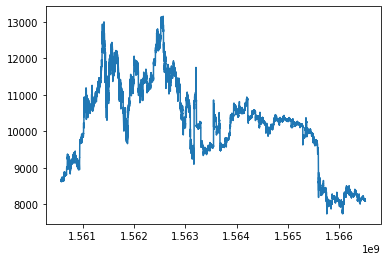

In [23]:
x = BTC_df.Datetime
y = BTC_df.Prices
plt.plot(x, y)
plt.show()

In [77]:
BTC_df['High'] = BTC_df.High.astype('float64')
BTC_df['Low'] = BTC_df.Low.astype('float64')
BTC_df['Volumes'] = BTC_df.Volumes.astype('float64')

In [78]:
ADL_avg = BTC_df.ADL.mean()
RSI_avg = BTC_df.RSI.mean()
ADL_slp_avg = BTC_df.ADL_slope.mean()
OBV_slp_avg = BTC_df.OBV_slope.mean()

In [79]:
values = {'OBV_slope': OBV_slp_avg, 'RSI': RSI_avg }
BTC_df = BTC_df.fillna(value=values)
BTC_df.head()

,Datetime,Prices,Volumes,High,Low,RSI,ADL,ADL_slope,OBV,OBV_slope
0,1560575162,8644.08,13197.701907,8644.86,8640.43,15.0,5203,-0.092510,8,-0.000454
1,1560575222,8644.08,13197.701907,8644.87,8640.50,15.0,10443,2.008249,5130,-0.092510
2,1560575282,8646.01,13197.701907,8646.01,8646.00,10.0,16145,1.985836,-5706,0.010063
3,1560575342,8646.01,13200.910764,8646.01,8646.00,9.0,9647,6.193095,5378,-0.003326
4,1560575402,8635.99,13200.910764,8635.37,8634.36,9.0,-4861,0.818087,10819,2.000370


In [80]:
BTC_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98852 entries, 0 to 98851
Data columns (total 10 columns):
Datetime     98852 non-null int64
Prices       98852 non-null float64
Volumes      98852 non-null float64
High         98852 non-null float64
Low          98852 non-null float64
RSI          98852 non-null float64
ADL          98852 non-null int64
ADL_slope    98852 non-null float64
OBV          98852 non-null int64
OBV_slope    98852 non-null float64
dtypes: float64(7), int64(3)
memory usage: 7.5 MB


In [81]:
np.random.seed(42)

In [88]:
X = BTC_df[['High', 'Low']].values
y = BTC_df['Prices'].values
print(X.shape)
print(y.shape)

(98852, 2)
(98852,)


In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [90]:
scalar = MinMaxScaler(feature_range=(0, 1))
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)

In [91]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

In [86]:
model = Sequential()

#input layer
model.add(LSTM(200, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

#hidden layer
model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.2))

# #hidden layer
model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.2))

# #hidden layer
model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.2))

# #hidden layer
model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.2))

# hidden layer
model.add(LSTM(200))
model.add(Dropout(0.2))

# output layer
model.add(Dense(1))

In [87]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mape'])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 2, 200)            161600    
_________________________________________________________________
dropout_54 (Dropout)         (None, 2, 200)            0         
_________________________________________________________________
lstm_55 (LSTM)               (None, 2, 200)            320800    
_________________________________________________________________
dropout_55 (Dropout)         (None, 2, 200)            0         
_________________________________________________________________
lstm_56 (LSTM)               (None, 2, 200)            320800    
_________________________________________________________________
dropout_56 (Dropout)         (None, 2, 200)            0         
_________________________________________________________________
lstm_57 (LSTM)               (None, 2, 200)           

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, shuffle=True, batch_size=32)

In [ ]:
model_loss = model.evaluate(X_test, y_test, verbose=2) #verbose=0
print(model_loss)